In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Dataset courtesy of Pierian Data (UDEMY)

df = pd.read_csv(r"C:\Users\bryan\Desktop\UDEMY_TSA_FINAL\Data\Alcohol_Sales.csv",index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df.columns = ['Sales']

In [5]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


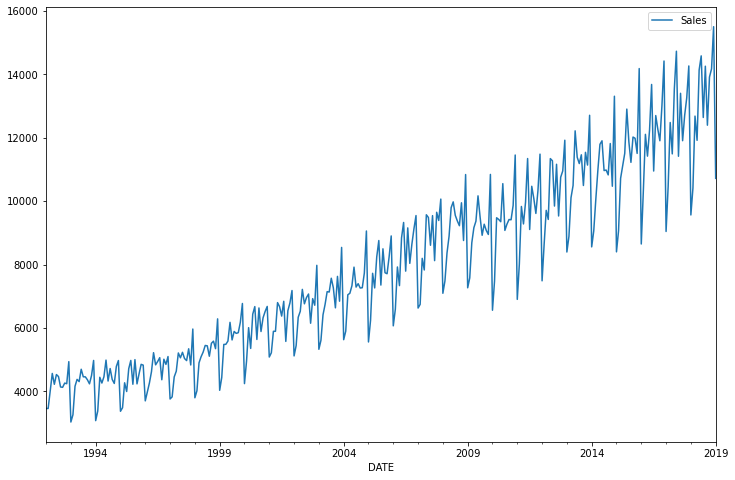

In [6]:
df.plot(figsize=(12,8))

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
results = seasonal_decompose(df['Sales'])

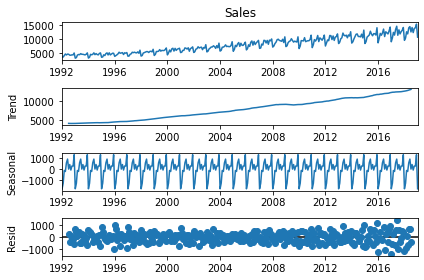

In [9]:
results.plot();

In [10]:
len(df)

325

In [11]:
325-12

313

In [12]:
train = df.iloc[:313]
test = df.iloc[313:]

In [13]:
ser = np.array([23,56,2,13,14])

In [14]:
ser.max()

56

In [15]:
ser / ser.max()

array([0.41071429, 1.        , 0.03571429, 0.23214286, 0.25      ])

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

In [18]:
scaler.fit(train)

MinMaxScaler()

In [19]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [20]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [21]:
n_input = 12
n_features = 1

generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input, batch_size=1)

In [22]:
len(scaled_train)

313

In [23]:
len(generator)

301

In [24]:
X, y = generator[0]

In [25]:
X

array([[[0.03658432],
        [0.03649885],
        [0.08299855],
        [0.13103684],
        [0.1017181 ],
        [0.12804513],
        [0.12266006],
        [0.09453799],
        [0.09359774],
        [0.10496624],
        [0.10334217],
        [0.16283443]]])

In [26]:
y

array([[0.]])

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [28]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input, batch_size=1)

In [29]:
model = Sequential()

model.add(LSTM(150,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit_generator(train_generator,epochs=50)

Epoch 1/50
301/301 [==============================] - 4s 13ms/step - loss: 0.0153
Epoch 2/50
301/301 [==============================] - 3s 9ms/step - loss: 0.0108
Epoch 3/50
301/301 [==============================] - 3s 10ms/step - loss: 0.0081
Epoch 4/50
301/301 [==============================] - 3s 9ms/step - loss: 0.0094
Epoch 5/50
301/301 [==============================] - 3s 10ms/step - loss: 0.0080
Epoch 6/50
301/301 [==============================] - 3s 9ms/step - loss: 0.0069
Epoch 7/50
301/301 [==============================] - 3s 10ms/step - loss: 0.0059
Epoch 8/50
301/301 [==============================] - 3s 10ms/step - loss: 0.0040
Epoch 9/50
301/301 [==============================] - 3s 10ms/step - loss: 0.0030
Epoch 10/50
301/301 [==============================] - 3s 10ms/step - loss: 0.0028
Epoch 11/50
301/301 [==============================] - 3s 10ms/step - loss: 0.0025
Epoch 12/50
301/301 [==============================] - 3s 9ms/step - loss: 0.0020
Epoch 13/50
301/3

In [32]:
model.history.history.keys()

dict_keys(['loss'])

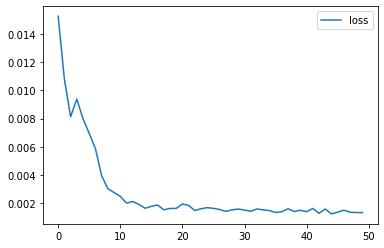

In [33]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [34]:
first_eval_batch = scaled_train[-12:]

In [35]:
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [36]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [37]:
first_eval_batch

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [38]:
model.predict(first_eval_batch)

array([[0.7031412]], dtype=float32)

# FORECAST

In [52]:
#holds predictions
test_predictions = []

#last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
#reshape this to the format RNN wants (1, inputs, features)
current_batch = first_eval_batch.reshape((1,n_input,n_features))

#how far into the future will I forecast?
#len(test)
for i in range(50):
    #one timestep ahead of historical 12 points
    current_pred = model.predict(current_batch)[0]
    #store prediction
    test_predictions.append(current_pred)
    #update current batch to include prediction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


In [53]:
current_batch.shape

(1, 12, 1)

In [54]:
current_batch

array([[[1.06316495],
        [1.00859332],
        [1.68298674],
        [0.83978057],
        [1.36359453],
        [0.81961644],
        [1.26571131],
        [0.89864862],
        [1.68603003],
        [0.70865226],
        [1.18814266],
        [0.82172406]]])

In [55]:
current_batch[:,1:,:]

array([[[1.00859332],
        [1.68298674],
        [0.83978057],
        [1.36359453],
        [0.81961644],
        [1.26571131],
        [0.89864862],
        [1.68603003],
        [0.70865226],
        [1.18814266],
        [0.82172406]]])

In [56]:
my_first_pred = model.predict(current_batch)[0]

In [57]:
np.append(current_batch[:,1:,:],[[my_first_pred]],axis=1)

array([[[1.00859332],
        [1.68298674],
        [0.83978057],
        [1.36359453],
        [0.81961644],
        [1.26571131],
        [0.89864862],
        [1.68603003],
        [0.70865226],
        [1.18814266],
        [0.82172406],
        [1.30288363]]])

In [58]:
test_predictions

[array([0.7285607], dtype=float32),
 array([0.82941186], dtype=float32),
 array([0.7977824], dtype=float32),
 array([0.94769394], dtype=float32),
 array([1.0472122], dtype=float32),
 array([0.77289784], dtype=float32),
 array([0.94376695], dtype=float32),
 array([0.7908325], dtype=float32),
 array([0.8928418], dtype=float32),
 array([0.9068277], dtype=float32),
 array([1.0139631], dtype=float32),
 array([0.6211492], dtype=float32),
 array([0.8127699], dtype=float32),
 array([0.8446034], dtype=float32),
 array([0.87493026], dtype=float32),
 array([0.9826374], dtype=float32),
 array([1.1201532], dtype=float32),
 array([0.8200977], dtype=float32),
 array([1.0125831], dtype=float32),
 array([0.8207331], dtype=float32),
 array([0.96277046], dtype=float32),
 array([0.9309187], dtype=float32),
 array([1.0900673], dtype=float32),
 array([0.678987], dtype=float32),
 array([0.89201236], dtype=float32),
 array([0.85714996], dtype=float32),
 array([0.9576837], dtype=float32),
 array([1.0050598], d

In [59]:
true_predictions = scaler.inverse_transform(test_predictions)

In [60]:
true_predictions

array([[11554.43146682],
       [12734.28940022],
       [12364.25654459],
       [14118.07145059],
       [15282.33603179],
       [12073.13182485],
       [14072.12956631],
       [12282.949646  ],
       [13476.35640478],
       [13639.97712445],
       [14893.35434544],
       [10297.82428396],
       [12539.59494114],
       [12912.01540244],
       [13266.80914176],
       [14526.87500572],
       [16135.67215466],
       [12625.32281518],
       [14877.2101146 ],
       [12632.7561903 ],
       [14294.45163536],
       [13921.81779575],
       [15783.69696152],
       [10974.46921968],
       [13466.65257287],
       [13058.79736578],
       [14234.94140089],
       [14789.19504821],
       [17777.02692878],
       [12993.66816914],
       [16095.50403643],
       [12857.71968758],
       [15402.32018971],
       [14024.18638873],
       [17457.57310045],
       [11492.74142647],
       [14580.36880863],
       [13121.33534086],
       [15468.96674323],
       [14830.53326058],


In [61]:
#test['Predictions'] = true_predictions

In [62]:
test

,Sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


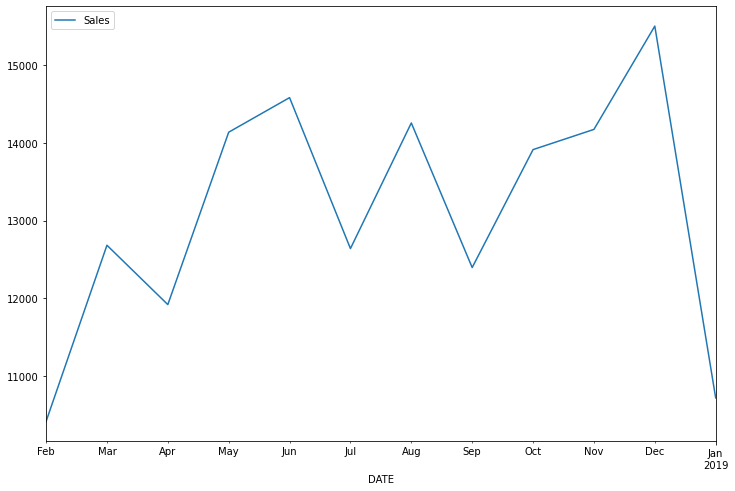

In [63]:
test.plot(figsize=(12,8))

In [64]:
len(test)

12

In [65]:
len(true_predictions)

50

In [66]:
type(test)

pandas.core.frame.DataFrame

In [81]:
true_pred = pd.read_excel(r"C:\Users\bryan\Desktop\Date_Sales.xlsx")

In [83]:
true_pred = true_pred.set_index('DATE')

In [87]:
both = pd.concat([test,true_pred])


In [88]:
both

,Sales
DATE,
2018-02-01,10415.000000
2018-03-01,12683.000000
2018-04-01,11919.000000
2018-05-01,14138.000000
2018-06-01,14583.000000
2018-07-01,12640.000000
2018-08-01,14257.000000
2018-09-01,12396.000000
2018-10-01,13914.000000


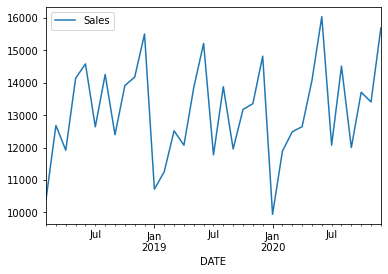

In [89]:
both.plot()